## Definitions

In [23]:
! pip install statsmodels
! pip install pytest
! pip install numpy nibabel nilearn neuroimagingtools

In [34]:
import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import glob

# SET PATHS:
# baseDir = '/Volumes/Diedrichsen_data$/data/Chord_exp/EFC_patternfMRI'
baseDir = '/Users/alighavampour/Desktop/Projects/EFC_patternfMRI/data'
# baseDir = '/Users/ali/Desktop/Projects/EFC_patternfMRI/data/fMRI'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


## USING RSA SPM OBJECT 

In [14]:
sn = 101
glm = 3
ses = 1
spm = spm_io.SpmGlm(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}'))
spm.get_info_from_spm_mat()
[beta, resMS, reg_info] =  spm.get_betas(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'mask.nii'))


## TIME SERIES

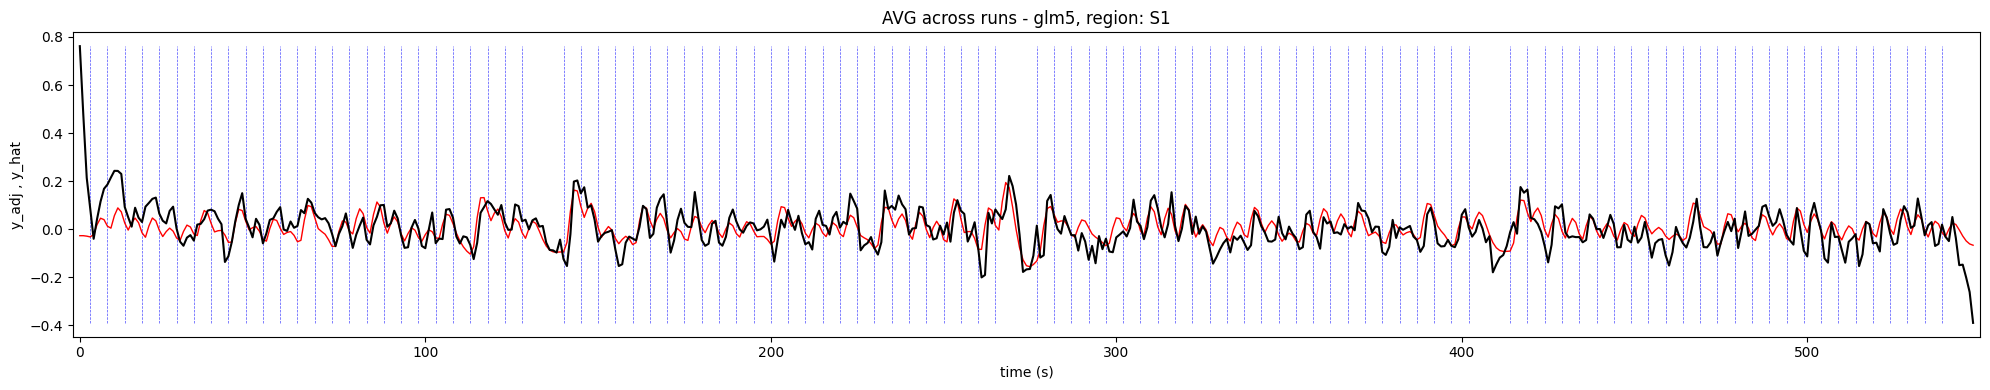

In [16]:
sn = 101
glm = 5
ses = 2
region = 1

# for cutting time series:
pre_idx = 6
post_idx = 16
TR = 1

roi_names = ['', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

D = pd.read_table(os.path.join(baseDir, behavDir, f's{sn}', f'ses-{ses:02d}', f'efc4_{sn}.dat'))
T = sio.loadmat(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'time_series_glm{glm}.mat'), simplify_cells=True)
SPM = sio.loadmat(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'SPM_v7.mat'), simplify_cells=True)
SPM = SPM['SPM']

X = SPM['xX']['X']
y_pred = np.sum(X[0:549, :], axis=1) - np.mean(np.sum(X[0:549, :], axis=1))
y_adj = T['y_adj']
y_hat = T['y_hat']
y_run_avg = np.zeros(549)
y_hat_avg = np.zeros(549)
y_pred = np.sum(SPM['xX']['X'][:549, :], axis=1) - np.mean(np.sum(SPM['xX']['X'][:549, :], axis=1))
y_pred = y_pred * 50
for run in range(0, 8):
    row = SPM['Sess'][run]['row']-1
    t = np.arange(0, len(row), 1)
    ons = D[D['BN']==run+1]['startTimeReal']/1000

    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    ax.vlines(ons, ymin=min(y_adj[row, region]), ymax=max(y_adj[row, region]), colors='b', lw=0.5, alpha=0.7, linestyles='--')
    # plt.plot(t, y_pred, color='r', ls='--', lw=0.7, alpha=0.6)
    plt.plot(t, y_hat[row, region], color='r', lw=1.5)
    plt.plot(t, y_adj[row, region], color='k', lw=1)
    plt.xlabel('time (s)')
    plt.ylabel('y adj')
    plt.xlim((t[0]-2, t[-1]+2))
    plt.title(f'run {run+1} - glm{glm}, region: {roi_names[region]}')
    plt.tight_layout()
    plt.savefig(f'./figures/efcp_Yadj_Yhat_glm{glm}_ses{ses}_run{run+1:02d}_{roi_names[region]}.pdf', bbox_inches="tight")
    # plt.show()
    plt.close()
    y_run_avg += y_adj[row, region]/8
    y_hat_avg += y_hat[row, region]/8

fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.vlines(ons, ymin=min(y_run_avg), ymax=max(y_run_avg), colors='b', lw=0.5, alpha=0.7, linestyles='--')
# plt.plot(t, y_pred, color='r', ls='--', lw=0.7, alpha=0.6)
plt.plot(t, y_hat_avg, color='r', lw=1)
plt.plot(t, y_run_avg, color='k', lw=1.5)
plt.xlabel('time (s)')
plt.ylabel('y_adj , y_hat')
plt.xlim((t[0]-2, t[-1]+2))
plt.title(f'AVG across runs - glm{glm}, region: {roi_names[region]}')
plt.tight_layout()
plt.savefig(f'./figures/efcp_Yadj_Yhat_glm{glm}_ses{ses}_avg_{roi_names[region]}.pdf', bbox_inches="tight")
plt.show()

'''
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TIME LOCKING AND AVERAGING THE TIME SERIES 
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
'''
def extract_snippets(y, pre, post, onsets):
    snippets_y = []

    for onset in onsets:
        start_idx = onset - pre
        end_idx = onset + post

        snippet_y = np.full(pre + post + 1, np.nan)
        
        valid_start = int(max(0, start_idx))
        valid_end = int(min(len(y), end_idx + 1))
        
        insert_start = int(valid_start - start_idx)
        insert_end = int(insert_start + (valid_end - valid_start))

        snippet_y[insert_start:insert_end] = y[valid_start:valid_end]
        
        snippets_y.append(snippet_y)
            
    return np.array(snippets_y)

# load the events:
events = pd.read_table(os.path.join(baseDir, behavDir, f's{sn}', f'ses-{ses:02d}', f'glm{glm}_events.tsv'))

# find the onsets of the events:
# T = events.copy()
# T['y_adj'] = np.nan
# T['y_hat'] = np.nan
T = pd.DataFrame()

blocks = np.unique(events['BN'])
for r in range(np.shape(y_adj)[1]):
    for i, BN in enumerate(blocks):
        tmp = pd.DataFrame()
        y_adj_reg = y_adj[SPM['Sess'][i]['row']-1, r]
        y_hat_reg = y_hat[SPM['Sess'][i]['row']-1, r]
        onsets = events[events['BN']==BN]['Onset']
        y_adj_cut = extract_snippets(y_adj_reg, pre_idx, post_idx, onsets)
        y_hat_cut = extract_snippets(y_hat_reg, pre_idx, post_idx, onsets)

        tmp = pd.concat([tmp, events[events['BN']==BN]], axis=1).reset_index(drop=True)
        tmp['region'] = r

        col_names = [f"y_adj{i}" for i in range(y_adj_cut.shape[1])]
        df_y_adj = pd.DataFrame(y_adj_cut, columns=col_names)
        tmp = pd.concat([tmp, df_y_adj], axis=1).reset_index(drop=True)

        col_names = [f"y_hat{i}" for i in range(y_hat_cut.shape[1])]
        df_y_hat = pd.DataFrame(y_hat_cut, columns=col_names)
        tmp = pd.concat([tmp, df_y_hat], axis=1).reset_index(drop=True)
        
        T = pd.concat([T, tmp], axis=0).reset_index(drop=True)

T.to_csv(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'time_series_cut_glm{glm}.csv'), index=False)


## TIME SERIES CUT

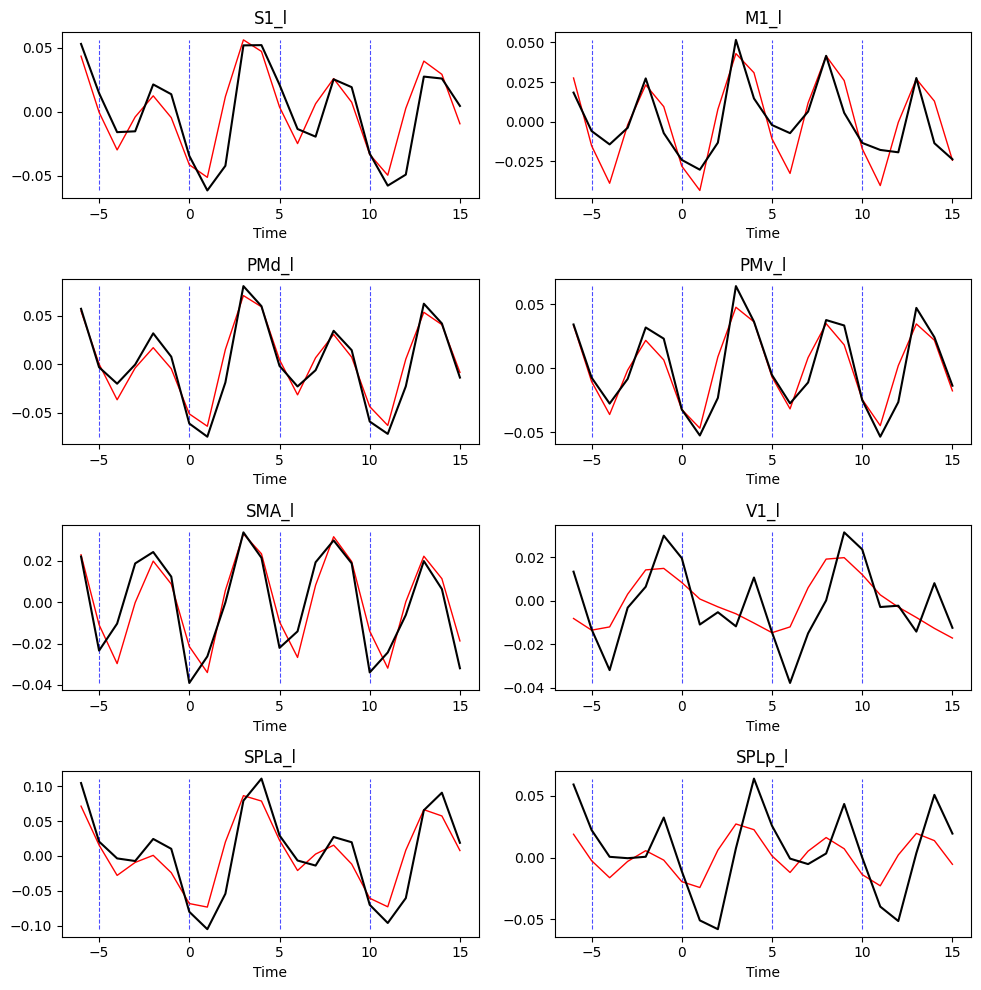

In [20]:
sn = 101
glm = 6
ses = 2

T = pd.read_csv(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'time_series_cut_glm{glm}.csv'))
T = T[T['repetition']==1]
t = np.arange(-6, 16, 1)
roi_names = ['_l', 'S1_l', 'M1_l', 'PMd_l', 'PMv_l', 'SMA_l', 'V1_l', 'SPLa_l', 'SPLp_l', '_r', 'S1_r', 'M1_r', 'PMd_r', 'PMv_r', 'SMA_r', 'V1_r', 'SPLa_r', 'SPLp_r']

n_row = 4
n_col = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))
for j, r in enumerate(range(1,9)):
    y_adj = T.loc[T['region']==r, [f'y_adj{i}' for i in range(len(t))]].mean().to_list()
    y_hat = T.loc[T['region']==r, [f'y_hat{i}' for i in range(len(t))]].mean().to_list()

    ax = axes[j//n_col, j%n_col]
    ax.vlines([-5,0,5,10], ymin=min(min(y_adj),min(y_hat)), ymax=max(max(y_adj),max(y_hat)), color='b', ls='--', lw=0.8, alpha=0.7)
    ax.plot(t, y_hat, color='r', lw=1)
    ax.plot(t, y_adj, color='k', lw=1.5)
    ax.set_title(f'{roi_names[r]}')
    ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig(f'./figures/efcp_Yhat_Yadj_my_glm{glm}_ses{ses}.pdf', bbox_inches="tight")
plt.show()

## Projection of t-values on surface

In [21]:
sn = 101
glm = 4
ses = 2

spmTs = list(Path(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}')).glob("spmT_*.nii"))
# spmTs = [spmTs[5]]

# 2. Define the relevant gifti files for both left and right hemisphere:
surf_white = [] # White -gray matter surface 
surf_pial = []  # Pial surface 
surf_sulc = []  # Sulcal depth 
hemN = ['L','R']
for h,hem in enumerate(hemN):
    surf_white.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.white.32k.surf.gii'))
    surf_pial.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.pial.32k.surf.gii'))
    surf_sulc.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.sulc.32k.shape.gii'))

# Map a Nifti to the surface of left hemisphere 
DL = surf.map.vol_to_surf(spmTs,surf_pial[0], surf_white[0], excludeThres=0.9)
# Map a Nifti to the surface of right hemisphere 
DR = surf.map.vol_to_surf(spmTs,surf_pial[1],surf_white[1],  excludeThres=0.9)

D = {'L':DL, 'R':DR}

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_73856/3670302172.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


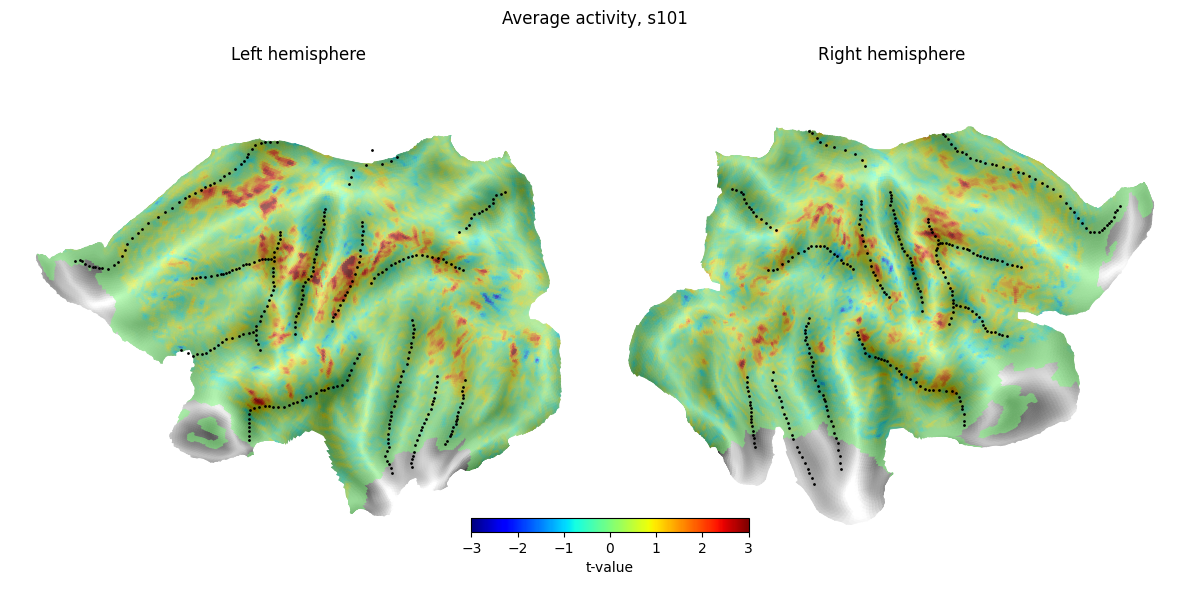

In [22]:
Hem = ['L', 'R']
region_names = ['?', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', '?']
Hem = ['L', 'R']
borders = {'L': './surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border',
           'R': './surfAnalysisPy/standard_mesh/fs_R/fs_LR.32k.R.border'}

vmin, vmax = -3, 3
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, H in zip(axs, Hem):
    plt.sca(ax)
    surf.plot.plotmap(D[H].mean(axis=1), f'fs32k_{H}',
                        underlay=None,
                        borders=borders[H],
                        cscale=[vmin, vmax],
                        cmap='jet',
                        underscale=[-1.5, 1],
                        alpha=.5,
                        new_figure=False,
                        colorbar=False,
                        # frame=[xlim[0], xlim[1], ylim[0], ylim[1]]
                        )
# make colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='jet')
cbar = fig.colorbar(sm, ax=[axs[0], axs[1]], orientation='horizontal', fraction=0.03)
cbar.set_label('t-value')

axs[0].set_title('Left hemisphere')
axs[1].set_title('Right hemisphere')
fig.suptitle(f'Average activity, s{sn}')
fig.tight_layout()
plt.savefig(f'./figures/efcp_spmT2surf_glm{glm}_ses{ses}.pdf', bbox_inches="tight")


## MEAN T-VALUES

In [ ]:
sn = 101
glm = 6
ses = 2
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

#  Define atlas map
white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.L.white.32k.surf.gii') # Individual white surface
pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.L.pial.32k.surf.gii') # Invividual pial surface
mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'mask.nii') # Mask in functional space for that subject

# File names for data extraction
nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', "beta_*.nii")))
nii_names = nii_names[0:416] # remove the run constant regressors
resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'ResMS.nii')]
spmT_names = glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', "spmT*.nii"))

beta = []
resMS = []
spmT = []
for i, r in enumerate(region_labels):
    print(f'Extracting region {region_names[i]} ({r})')
    atlas,_ = am.get_atlas('fs32k')
    atlas_left = atlas.get_hemisphere(0)
    subatlas = atlas_left.get_subatlas_image(os.path.join(atlasDir,'ROI.32k.L.label.gii'), value=r)
    amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
    # Compute the voxels in native space
    amap.build()

    # This extract all the relevant voxels in native space (use for RSA)
    beta.append(amap.extract_data_native(nii_names))
    resMS.append(amap.extract_data_native(resMS_name))
    spmT.append(amap.extract_data_native(spmT_names))

regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'reginfo.tsv'))

Extracting region S1 (1)
Extracting region M1 (2)
Extracting region PMd (3)
Extracting region PMv (4)
Extracting region SMA (5)
Extracting region V1 (6)
Extracting region SPLa (7)
Extracting region SPLp (8)


In [ ]:
mean_t = np.array([])
sem_t = np.array([])
spmT_avg = np.array([])
for i, r in enumerate(region_labels):
    t_map = np.mean(spmT[i], axis=1)
    spmT_avg = np.vstack((spmT_avg, t_map)) if spmT_avg.size else t_map
x = np.repeat(np.array(region_labels), len(spmT[0]))

# box plot:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.boxplot(x=x, y=spmT_avg.flatten(), ax=ax)

ax.set_xticks(np.arange(0,10))
ax.set_xticklabels(region_names)
plt.xlabel('Region')
plt.ylabel('t-value')
plt.title(f'glm{glm} - ses{ses}')

# Make it pretty:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

# plt.savefig(os.path.join('figures','ef_snr.pdf'), format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


(52, 940)
(52, 518)
(52, 1355)
(52, 432)
(52, 776)
(52, 1340)
(52, 846)
(52, 1003)
